# KAGGLE比赛 - 房价预测

## 1. 获取和读取数据集

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import d2lzh_pytorch as d2l
import matplotlib.pylab as plt

print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.3.0


In [2]:
train_data = pd.read_csv('kaggle_dataset/house_price/train.csv')
test_data = pd.read_csv('kaggle_dataset/house_price/test.csv')

In [3]:
train_data.iloc[0:1, [1,2,3,-1]]

,MSSubClass,MSZoning,LotFrontage,SalePrice
0,60,RL,65.0,208500


In [4]:
all_features = pd.concat((train_data.iloc[:, 1:-1],test_data.iloc[:, 1:]))

## 2. 数据预处理

### 标准化处理

$$x_i = \frac{x_i-\mu }{\sigma }$$

In [5]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x-x.mean())/(x.std())
)
all_features = all_features.fillna(0)
all_features.iloc[0:10, [1,2,3,4,5]]

,MSZoning,LotFrontage,LotArea,Street,Alley
0,RL,-0.184443,-0.217841,Pave,0
1,RL,0.458096,-0.072032,Pave,0
2,RL,-0.055935,0.137173,Pave,0
3,RL,-0.398622,-0.078371,Pave,0
4,RL,0.629439,0.518814,Pave,0
5,RL,0.672275,0.500430,Pave,0
6,RL,0.243916,-0.010665,Pave,0
7,RL,0.000000,0.027119,Pave,0
8,RM,-0.784145,-0.513264,Pave,0
9,RL,-0.826981,-0.348436,Pave,0


### 将离散数值转化为指示特征

In [6]:
all_features = pd.get_dummies(all_features, dummy_na=True)
print(all_features.shape)
print(train_data.shape)
print(test_data.shape)
all_features.iloc[0:10, [0, 1,2,-1,-2,-3,-4,-5,-6,-7]]

(2919, 354)
(1460, 81)
(1459, 80)


,MSSubClass,LotFrontage,LotArea,SaleCondition_nan,SaleCondition_Partial,SaleCondition_Normal,SaleCondition_Family,SaleCondition_Alloca,SaleCondition_AdjLand,SaleCondition_Abnorml
0,0.067320,-0.184443,-0.217841,0,0,1,0,0,0,0
1,-0.873466,0.458096,-0.072032,0,0,1,0,0,0,0
2,0.067320,-0.055935,0.137173,0,0,1,0,0,0,0
3,0.302516,-0.398622,-0.078371,0,0,0,0,0,0,1
4,0.067320,0.629439,0.518814,0,0,1,0,0,0,0
5,-0.167877,0.672275,0.500430,0,0,1,0,0,0,0
6,-0.873466,0.243916,-0.010665,0,0,1,0,0,0,0
7,0.067320,0.000000,0.027119,0,0,1,0,0,0,0
8,-0.167877,-0.784145,-0.513264,0,0,0,0,0,0,1
9,3.124875,-0.826981,-0.348436,0,0,1,0,0,0,0


## 3. 创建模型

选用MSELoss和Adam

In [87]:
loss = nn.MSELoss()

def get_net(feature_num):
    net = nn.Sequential(
        nn.Linear(feature_num, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 1),
#         nn.ReLU(),
#         nn.Dropout(0.4),
#         nn.Linear(32, 1)
    )
    # 在此处初始化
    #
    
    return net

在kaggle比赛中，我们使用均方根对数误差

$$\sqrt{\frac{1}{n}\sum_{i=1}^{n}(\log (y_i)-log(\hat{y}_i))^2}.$$

In [46]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的变成1
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2 * loss(clipped_preds.view(-1).log(), labels.log()).mean())
    return rmse.item()

In [47]:
def train(net, train_features, train_labels, test_features, test_labels,
         num_epochs, learning_rate, weight_decay, batch_size):
    train_loss, test_loss = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    # use Adam
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            out = net(X.float())
            l = loss(out, y.float().view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
                        
        train_loss.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_loss.append(log_rmse(net, test_features, test_labels))
    return train_loss, test_loss

## 4. K折交叉验证

In [67]:
# 获取数据
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j+1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j==i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, 
          learning_rate, weight_decay, batch_size):
    train_loss_sum, valid_loss_sum = torch.zeros(num_epochs), torch.zeros(num_epochs)
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_loss, valid_loss = train(net, *data, num_epochs,
                                      learning_rate, weight_decay, batch_size)
        train_loss_sum += torch.tensor(train_loss)
        valid_loss_sum += torch.tensor(valid_loss)
    plt.semilogy(range(1, num_epochs+1), train_loss_sum/k, label="train")
    plt.semilogy(range(1, num_epochs+1), valid_loss_sum/k, label="valid", linestyle=':')
    plt.legend(loc=1)
    plt.title('rmse decend with epochs')
    plt.show()
    print('final rmse: ', valid_loss_sum[-1]/k)

In [94]:
X_train = torch.tensor(np.array(all_features.iloc[:train_data.shape[0]]), dtype=torch.float)
y_train = torch.tensor(train_data.iloc[:,-1], dtype=torch.float)

X_test = torch.tensor(np.array(all_features.iloc[test_data.shape[0]+1:]), dtype=torch.float)
print(X_test.shape)

torch.Size([1459, 354])


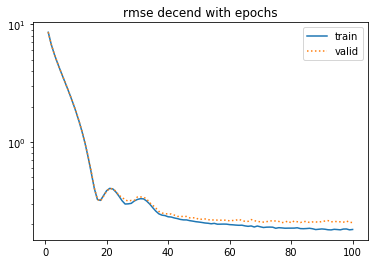

final rmse:  tensor(0.2073)


In [89]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.2, 10, 1000
k_fold(k, X_train, y_train, num_epochs,
      lr, weight_decay, batch_size)

In [100]:
def train_and_pred(train_features, test_features, train_labels,
                  test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_loss, _ = train(net, train_features, train_labels,
                         None, None, num_epochs, lr,
                         weight_decay, batch_size)
    plt.semilogy(range(1, num_epochs+1), train_loss, label="train")
    plt.legend(loc=1)
    plt.title('rmse decend with epochs')
    plt.show()
    print('train rmse: ', train_loss[-1])
    
    preds = net(test_features).detach().numpy().reshape(1, -1)[0]
    test_data['SalePrice'] = pd.Series(preds)
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)

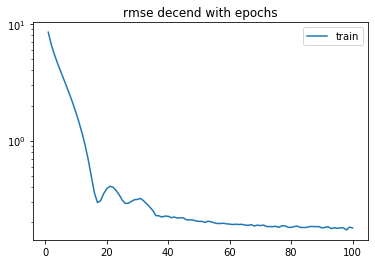

train rmse:  0.1785474568605423


In [101]:
train_and_pred(X_train, X_test, y_train, test_data,
              num_epochs, lr, weight_decay, batch_size)

# 结束 最后拿到了0.14174 2577名